# Рыночный граф

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
import networkx as nx

Данные с сайта https://daytradingschool.ru/trejderu/skachat-kotirovki-istoricheskie-dannye-po-fyuchersam/   

Список Акций Московской биржи       
Интервал 18.05.2022_18.05.2023   
Разделитель полей ";"    
Десятичный разделитель "."

Данные предобработаны - оставлены только необходимые столбцы ('TICKER', 'DATE', 'CLOSE')

In [2]:
from os import walk

files = []
for (dirpath, dirnames, filenames) in walk('data/'):
    files.extend(filenames)
    break

In [3]:
# # optional
# files.remove('.DS_Store')
# len(files)

Обработка файла и подсчет логарифмической доходности

In [4]:
def metrics(filename):
    file_df = pd.read_csv('data/'+filename, delimiter=',',skiprows=[0,],
                      names=['TICKER', 'DATE', 'CLOSE'])
    file_df = file_df[file_df['DATE'] >= (file_df['DATE'].values[-1] - 10000)]
    file_df = file_df.drop_duplicates(subset=['DATE'], keep='last')
    file_df = file_df.reset_index()
    file_df.drop('index', axis=1, inplace=True)
    file_df['CLOSE_shift'] = file_df.CLOSE.shift(1)
    file_df['Ri'] = np.log(file_df.CLOSE /file_df.CLOSE_shift)
    return file_df

Подсчет коэффициента корреляции двух акций (средняя доходность акции i за n дней и дисперсия за один день акции i)

In [5]:
def coeff(df1, df2):
    df1_E_Ri = df1.Ri.mean()
    df1_Var_Ri = (np.power(df1.Ri - df1.Ri.mean(), 2)).sum()/df1.Ri.count()
    df2_E_Ri = df2.Ri.mean()
    df2_Var_Ri = (np.power(df2.Ri - df2.Ri.mean(), 2)).sum()/df2.Ri.count()
    return ((df1.Ri * df2.Ri).mean() - (df1_E_Ri * df2_E_Ri)) / np.sqrt(df1_Var_Ri * df2_Var_Ri)

In [6]:
coeff_df = pd.DataFrame([], columns=['company1', 'company2', 'coeff'])

In [7]:
%%time
# список files - это список с названиями файлов txt, содержащих котировки

for i in files:
    for j in files:
        if i != j:
            if coeff_df.loc[(coeff_df['company1'] == j.split('.')[0])&(coeff_df['company2'] == i.split('.')[0])].empty:
                df_i = metrics(i)
                df_j = metrics(j)
                coeff_df.loc[len(coeff_df.index)] = [i.split('.')[0], j.split('.')[0], coeff(df_i, df_j)]

CPU times: user 9min 49s, sys: 2min 7s, total: 11min 57s
Wall time: 12min


Плотность распределения коэффициентов корреляции

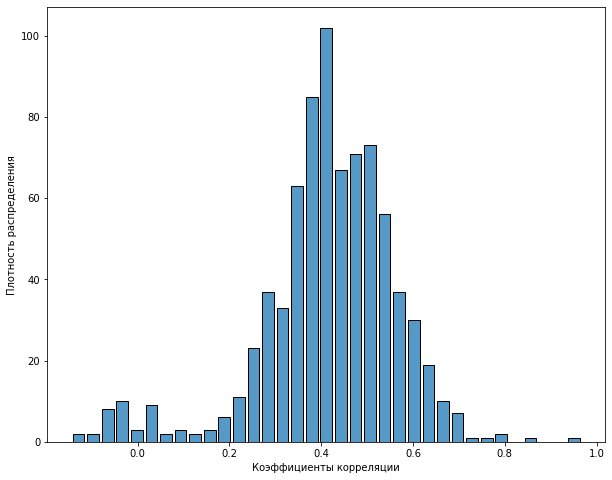

In [12]:
plt.figure(figsize=(10,8)) 
ax = sns.histplot(data=coeff_df, x="coeff", shrink=.8)
ax.set(xlabel='Коэффициенты корреляции', ylabel='Плотность распределения')
plt.show()

Построение рыночного графа

In [13]:
G = nx.Graph()
for index, row in coeff_df.iterrows():
    G.add_edge(row[0], row[1], coefficient=row[2])

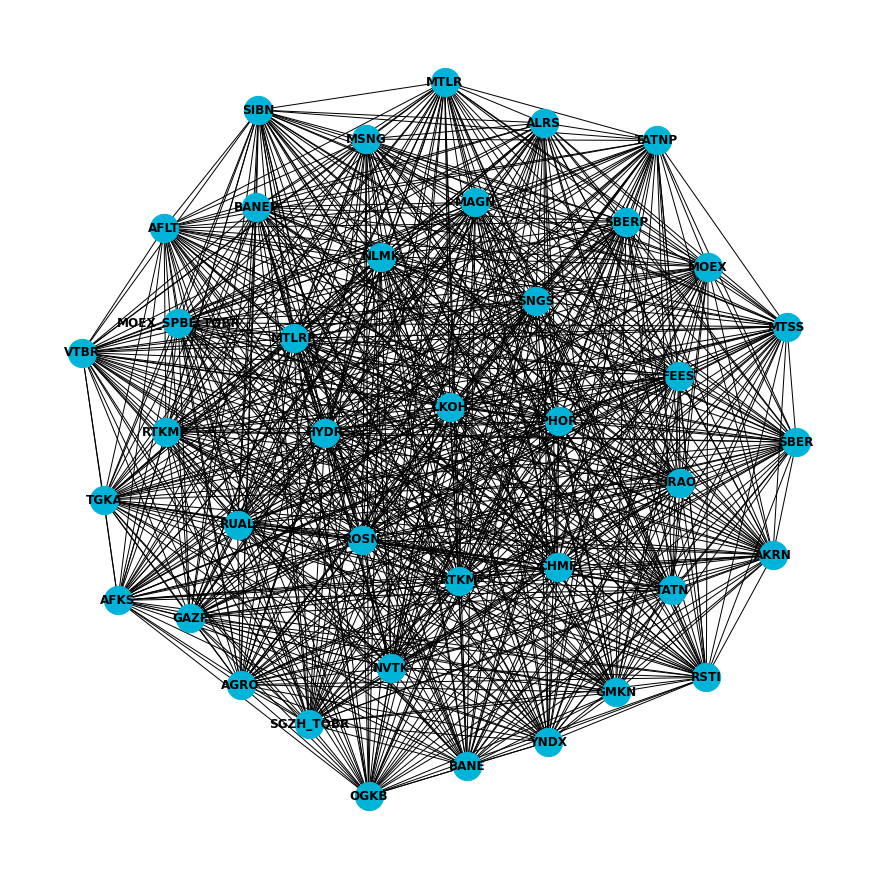

In [14]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G, with_labels=True, font_weight='bold', node_size=800, node_color='#00b4d9')
plt.show()

In [15]:
len(files), len(G.nodes)

(40, 40)

График плотности рёбер рыночного графа

-1.0 1.0
-0.95 1.0
-0.8999999999999999 1.0
-0.8499999999999999 1.0
-0.7999999999999998 1.0
-0.7499999999999998 1.0
-0.6999999999999997 1.0
-0.6499999999999997 1.0
-0.5999999999999996 1.0
-0.5499999999999996 1.0
-0.49999999999999956 1.0
-0.4499999999999995 1.0
-0.39999999999999947 1.0
-0.3499999999999994 1.0
-0.2999999999999994 1.0
-0.24999999999999933 1.0
-0.1999999999999993 1.0
-0.14999999999999925 1.0
-0.0999999999999992 1.0
-0.049999999999999156 0.98
8.881784197001252e-16 0.97
0.05000000000000093 0.96
0.10000000000000098 0.95
0.15000000000000102 1.0
0.20000000000000107 0.99
0.2500000000000011 0.96
0.30000000000000115 0.89
0.3500000000000012 0.81
0.40000000000000124 0.63
0.4500000000000013 0.5
0.5000000000000013 0.34
0.5500000000000014 0.26
0.6000000000000014 0.22
0.6500000000000015 0.16
0.7000000000000015 0.12
0.7500000000000016 0.14
0.8000000000000016 0.2
0.8500000000000016 0.33
0.9000000000000017 1.0
0.9500000000000017 1.0


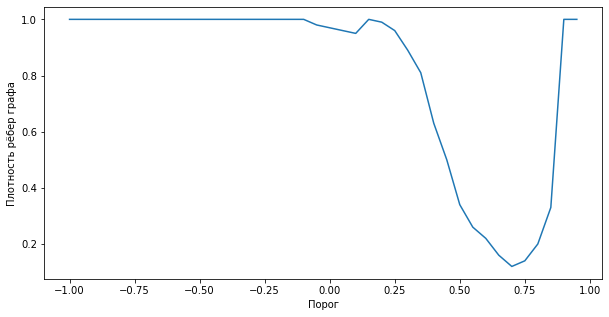

In [16]:
thresholds_list = np.arange(-1, 1, step=0.05)

density_list = []

G = nx.Graph()
for index, row in coeff_df.iterrows():
    G.add_edge(row[0], row[1], coefficient=row[2])
    
for i in thresholds_list:
    threshold = i
    remove = [(u, v) for u, v, a in G.edges(data=True) if a['coefficient'] < threshold]
    G.remove_edges_from(remove)
    remove_zero = [node for node,degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(remove_zero)
    density_list.append(np.round(nx.density(G), 2))
    print(i, density_list[-1])
    
    
plt.figure(figsize=(10,5)) 
ax1 = sns.lineplot(x=thresholds_list, y=density_list)
ax1.set(xlabel='Порог', ylabel='Плотность рёбер графа')
plt.show()

Максимальные клики для пороговых значений 0.9-0.95

In [17]:
thresholds_list = [0.9, 0.95]

density_list = []
G = nx.Graph()
for index, row in coeff_df.iterrows():
    G.add_edge(row[0], row[1], coefficient=row[2])
    
for i in thresholds_list:
    threshold = i
    remove = [(u, v) for u, v, a in G.edges(data=True) if a['coefficient'] < threshold]
    G.remove_edges_from(remove)
    remove_zero = [node for node,degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(remove_zero)
    print(f'Порог: {i} | плотность: {np.round(nx.density(G), 2)}')
    cliques = list(nx.find_cliques(G))
    cliques_len = max([len(i) for i in cliques])
    cliques_max = [cl for cl in cliques if len(cl) == cliques_len]
    print(f'{cliques_len}: {cliques_max}')
    print('_______\n')

Порог: 0.9 | плотность: 1.0
2: [['SBERP', 'SBER']]
_______

Порог: 0.95 | плотность: 1.0
2: [['SBERP', 'SBER']]
_______



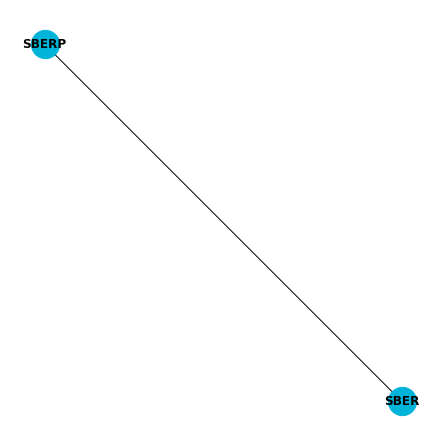

In [18]:
plt.figure(3,figsize=(6,6)) 
nx.draw(G, with_labels=True, font_weight='bold', node_size=800, node_color='#00b4d9')
plt.show()

Максимальные клики для пороговых значений (0,6-0,8) 

In [19]:
thresholds_list = [0.6, 0.65, 0.7, 0.75, 0.8]

density_list = []
G = nx.Graph()
for index, row in coeff_df.iterrows():
    G.add_edge(row[0], row[1], coefficient=row[2])
    
for i in thresholds_list:
    threshold = i
    remove = [(u, v) for u, v, a in G.edges(data=True) if a['coefficient'] < threshold]
    G.remove_edges_from(remove)
    remove_zero = [node for node,degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(remove_zero)
    print(f'Порог: {i} | плотность: {np.round(nx.density(G), 2)}')
    cliques = list(nx.find_cliques(G))
    cliques_len = max([len(i) for i in cliques])
    cliques_max = [cl for cl in cliques if len(cl) == cliques_len]
    print(f'{cliques_len}: {cliques_max}')
    print('_______\n')

Порог: 0.6 | плотность: 0.22
5: [['ROSN', 'AFKS', 'SBER', 'SBERP', 'GMKN'], ['ROSN', 'AFKS', 'SBER', 'SBERP', 'MOEX'], ['ROSN', 'AFKS', 'SBER', 'SBERP', 'SNGS'], ['ROSN', 'AFKS', 'SBER', 'SBERP', 'NLMK'], ['ROSN', 'AFKS', 'SBER', 'SBERP', 'VTBR'], ['ROSN', 'AFKS', 'SBER', 'NVTK', 'NLMK']]
_______

Порог: 0.65 | плотность: 0.16
3: [['ROSN', 'TATNP', 'TATN'], ['ROSN', 'AFKS', 'TATN'], ['ROSN', 'AFKS', 'NLMK'], ['ROSN', 'AFKS', 'SBER'], ['ROSN', 'AFKS', 'SNGS'], ['CHMF', 'NLMK', 'MAGN'], ['SBERP', 'SBER', 'VTBR'], ['SBERP', 'SBER', 'AFKS']]
_______

Порог: 0.7 | плотность: 0.12
3: [['NLMK', 'CHMF', 'MAGN']]
_______

Порог: 0.75 | плотность: 0.14
2: [['CHMF', 'NLMK'], ['SBERP', 'SBER'], ['RTKM', 'RTKMP'], ['TATN', 'TATNP']]
_______

Порог: 0.8 | плотность: 0.2
2: [['CHMF', 'NLMK'], ['SBERP', 'SBER'], ['TATN', 'TATNP']]
_______



GMKN   |  "ГМК «Нор.Никель» ПАО ао"  |  ПРОЧИЕ МЕТАЛЛЫ И МИНЕРАЛЫ (ОТРАСЛЬ)        
AFKS   |  "АФК «Система» ПАО ао"  |  БЕСПРОВОДНЫЕ ТЕЛЕКОММУНИКАЦИИ (ОТРАСЛЬ)        
RTKMP  |  "Ростелеком (ПАО) ап- Акция привилегированная"  |   ВЕДУЩИЕ ТЕЛЕКОММУНИКАЦИОННЫЕ КОМПАНИИ (ОТРАСЛЬ)         
AFLT   |  "Аэрофлот-росс.авиалин(ПАО) ао"  |   АВИАКОМПАНИИ (ОТРАСЛЬ)           
MTLRP  |  "ПАО «Мечел», Акция привилегированная"  |  СТАЛЬ (ОТРАСЛЬ)        
BANE   |  "Башнефть АНК ао"  |  ИНТЕГРИРОВАННАЯ НЕФТЯНАЯ ПРОМЫШЛЕННОСТЬ (ОТРАСЛЬ)        
TATN   |  "ПАО «Татнефть» ао"  |  ПЕРЕРАБОТКА И ПРОДАЖА НЕФТИ (ОТРАСЛЬ)        
MOEX   |  "ПАО Московская Биржа"  |  ИНВЕСТИЦИОННЫЕ БАНКИ, БРОКЕРЫ (ОТРАСЛЬ)        
SBERP  |  "Сбербанк России ПАО ап"  |   РЕГИОНАЛЬНЫЕ БАНКИ (ОТРАСЛЬ)        
CHMF   |  "Северсталь (ПАО) ао"  |  СТАЛЬ (ОТРАСЛЬ)        
RTKM   |  "Ростелеком (ПАО) ао"  |  ВЕДУЩИЕ ТЕЛЕКОММУНИКАЦИОННЫЕ КОМПАНИИ (ОТРАСЛЬ)        
SNGS   |  "ПАО Сургутнефтегаз, акции об."  |  ИНТЕГРИРОВАННАЯ НЕФТЯНАЯ ПРОМЫШЛЕННОСТЬ (ОТРАСЛЬ)        
NVTK   |  "ПАО «НОВАТЭК» ао"  |  ИНТЕГРИРОВАННАЯ НЕФТЯНАЯ ПРОМЫШЛЕННОСТЬ (ОТРАСЛЬ)        
VTBR   |  "обыкновенные акции Банк ВТБ"  |   РЕГИОНАЛЬНЫЕ БАНКИ (ОТРАСЛЬ)          
MAGN   |  "Магнитогорск.мет.комб ПАО ао — ММК"  |  СТАЛЬ (ОТРАСЛЬ)        
SBER   |  "Сбербанк России ПАО ао"  |  РЕГИОНАЛЬНЫЕ БАНКИ (ОТРАСЛЬ)        
BANEP  |  "Башнефть АНК ап — Акция привилегированная"  |  ИНТЕГРИРОВАННАЯ НЕФТЯНАЯ ПРОМЫШЛЕННОСТЬ (ОТРАСЛЬ)        
ROSN   |  "акции ОАО «НК «Роснефть»"   |  ИНТЕГРИРОВАННАЯ НЕФТЯНАЯ ПРОМЫШЛЕННОСТЬ (ОТРАСЛЬ)        
ALRS   |  "АЛРОСА ПАО ао"  |  ПРОЧИЕ МЕТАЛЛЫ И МИНЕРАЛЫ (ОТРАСЛЬ)        
NLMK   |  "ПАО «НЛМК» ао"   |  СТАЛЬ (ОТРАСЛЬ)        
TATNP  |  "ПАО «Татнефть» Зап — Акция привилегированная"  |  ПЕРЕРАБОТКА И ПРОДАЖА НЕФТИ (ОТРАСЛЬ)        
MTLR   |  "ПАО «Мечел», акция обыкн."   |  СТАЛЬ (ОТРАСЛЬ)        
YNDX   |  "ПКОО Яндекс Н.В. — Public Limited Liability Company Yandex N.V."  |  ИНТЕРНЕТ-СЕРВИСЫ И ПО (ОТРАСЛЬ)
